In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 4.4198e-05

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 874ms/step - loss: 3.4648e-05
Average validation loss: 0.7232547998428345
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 886ms/step - loss: 3.4648e-05 - val_loss: 0.7233
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 884ms/step - loss: 2.5382e-05 - val_loss: 0.7233
Average validation loss: 0.7037108540534973
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 896ms/step - loss: 2.5382e-05 - val_loss: 0.7135
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 873ms/step - loss: 2.0884e-05 - val_loss: 0.7135
Average validation loss: 0.7006554007530212
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 885ms/step - loss: 2.0884e-05 - val_loss: 0.7092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weight

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 902ms/step - loss: 1.2872e-06
Average validation loss: 0.0999260414391756
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 915ms/step - loss: 1.2872e-06 - val_loss: 0.0999
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 908ms/step - loss: 1.1998e-06 - val_loss: 0.0999
Average validation loss: 0.13991499319672585
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 921ms/step - loss: 1.1998e-06 - val_loss: 0.1199
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 897ms/step - loss: 1.1454e-06 - val_loss: 0.1199
Average validation loss: 0.25204192847013474
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 908ms/step - loss: 1.1454e-06 - val_loss: 0.1640
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 865ms/step - loss: 1.0870e-06 - val_loss: 0.1640
Average validation loss: 0.170501496642828
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 877ms/step - loss: 1.0870e-06 - val_loss: 0.1656
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 784ms/step - loss: 1.0132e-06
Average validation loss: 0.07707942028840382
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 796ms/step - loss: 1.0132e-06 - val_loss: 0.0771
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 793ms/step - loss: 9.3534e-07 - val_loss: 0.0771
Average validation loss: 0.01745212326447169
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 804ms/step - loss: 9.3534e-07 - val_loss: 0.0473
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 806ms/step - loss: 7.9478e-07 - val_loss: 0.0473
Average validation loss: 0.016865750153859455
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 819ms/step - loss: 7.9478e-07 - val_loss: 0.0371
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 842ms/step - loss: 3.6659e-07
Average validation loss: 0.024232912925072014
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 853ms/step - loss: 3.6659e-07 - val_loss: 0.0242
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 828ms/step - loss: 3.2497e-07 - val_loss: 0.0242
Average validation loss: 0.03367419808637351
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 839ms/step - loss: 3.2497e-07 - val_loss: 0.0290
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 830ms/step - loss: 3.0452e-07 - val_loss: 0.0290
Average validation loss: 0.0350685880985111
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 842ms/step - loss: 3.0452e-07 - val_loss: 0.0310
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 819ms/step - loss: 2.6700e-07 - val_loss: 0.0310
Average validation loss: 0.037366146803833544
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 831ms/step - loss: 2.6700e-07 - val_loss: 0.0326
Epoch 5/10
16

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 819ms/step - loss: 2.7703e-07
Average validation loss: 0.019302849378436803
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 829ms/step - loss: 2.7703e-07 - val_loss: 0.0193
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 799ms/step - loss: 2.3251e-07 - val_loss: 0.0193
Average validation loss: 0.020236890576779843
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 809ms/step - loss: 2.3251e-07 - val_loss: 0.0198
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 838ms/step - loss: 2.0389e-07 - val_loss: 0.0198
Average validation loss: 0.01678979005664587
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 848ms/step - loss: 2.0389e-07 - val_loss: 0.0188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 796ms/step - loss: 1.7982e-07 - va

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 805ms/step - loss: 2.0828e-07
Average validation loss: 0.011009181112361452
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 815ms/step - loss: 2.0828e-07 - val_loss: 0.0110
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 795ms/step - loss: 1.7901e-07 - val_loss: 0.0110
Average validation loss: 0.010255104697231824
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 804ms/step - loss: 1.7901e-07 - val_loss: 0.0106
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 795ms/step - loss: 1.5473e-07 - val_loss: 0.0106
Average validation loss: 0.01014461979502812
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 805ms/step - loss: 1.5473e-07 - val_loss: 0.0105
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_K

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 767ms/step - loss: 5.7741e-07
Average validation loss: 0.023132936260662974
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 777ms/step - loss: 5.7741e-07 - val_loss: 0.0231
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 765ms/step - loss: 4.4782e-07 - val_loss: 0.0231
Average validation loss: 0.030098228401038797
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 776ms/step - loss: 4.4782e-07 - val_loss: 0.0266
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 792ms/step - loss: 3.8219e-07 - val_loss: 0.0266
Average validation loss: 0.023608851834433155
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 802ms/step - loss: 3.8219e-07 - val_loss: 0.0256
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 794ms/step - loss: 3.3257e-07 - val_loss: 0.0256
Average validation loss: 0.02834116874728352
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 805ms/step - loss: 3.3257e-07 - val_loss: 0.0263
Epoch 5/1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 785ms/step - loss: 3.6538e-07
Average validation loss: 0.03195383995383357
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 797ms/step - loss: 3.6538e-07 - val_loss: 0.0320
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 828ms/step - loss: 2.9145e-07 - val_loss: 0.0320
Average validation loss: 0.016662786016240716
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 840ms/step - loss: 2.9145e-07 - val_loss: 0.0243
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 829ms/step - loss: 2.3526e-07 - val_loss: 0.0243
Average validation loss: 0.018293191057940323
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 841ms/step - loss: 2.3526e-07 - val_loss: 0.0223
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 158s 818ms/step - loss: 2.0281e-07 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 810ms/step - loss: 9.3788e-08
Average validation loss: 0.03388453995077206
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 821ms/step - loss: 9.3788e-08 - val_loss: 0.0339
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 840ms/step - loss: 8.4234e-08 - val_loss: 0.0339
Average validation loss: 0.021846274296487018
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 851ms/step - loss: 8.4234e-08 - val_loss: 0.0279
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 820ms/step - loss: 7.3916e-08 - val_loss: 0.0279
Average validation loss: 0.034812608550834866
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 831ms/step - loss: 7.3916e-08 - val_loss: 0.0302
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 187s 833ms/step - loss: 6.8763e-08 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 797ms/step - loss: 1.7580e-07
Average validation loss: 0.02346949209459126
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 809ms/step - loss: 1.7580e-07 - val_loss: 0.0235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 793ms/step - loss: 1.3825e-07 - val_loss: 0.0235
Average validation loss: 0.024561509082559496
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 805ms/step - loss: 1.3825e-07 - val_loss: 0.0240
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 794ms/step - loss: 1.1210e-07 - val_loss: 0.0240
Average validation loss: 0.024473601966747083
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 805ms/step - loss: 1.1210e-07 - val_loss: 0.0242
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 206s 801ms/step - loss: 9.4592e-08 - val_loss: 0.0242
Average validation loss: 0.02776562504004687
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 812ms/step - loss: 9.4592e-08 - val_loss: 0.0251
Epoch 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 792ms/step - loss: 9.1070e-08
Average validation loss: 0.02094021519587841
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 803ms/step - loss: 9.1070e-08 - val_loss: 0.0209
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 794ms/step - loss: 7.0246e-08 - val_loss: 0.0209
Average validation loss: 0.022092854266197212
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 804ms/step - loss: 7.0246e-08 - val_loss: 0.0215
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 795ms/step - loss: 6.0251e-08 - val_loss: 0.0215
Average validation loss: 0.023122849851562124
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 806ms/step - loss: 6.0251e-08 - val_loss: 0.0221
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 231s 793ms/step - loss: 5.3796e-08 - val_loss: 0.0221
Average validation loss: 0.021530576839318707
72/72 ━━━━━━━━━━━━━━━━━━━━ 232s 804ms/step - loss: 5.3796e-08 - val_loss: 0.0219
Epoch

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 794ms/step - loss: 9.5203e-08
Average validation loss: 0.024699831521138547
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 805ms/step - loss: 9.5203e-08 - val_loss: 0.0247
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 807ms/step - loss: 7.5930e-08 - val_loss: 0.0247
Average validation loss: 0.018562346452381463
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 818ms/step - loss: 7.5930e-08 - val_loss: 0.0216
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 201s 884ms/step - loss: 6.3595e-08 - val_loss: 0.0216
Average validation loss: 0.01840146861213725
80/80 ━━━━━━━━━━━━━━━━━━━━ 202s 895ms/step - loss: 6.3595e-08 - val_loss: 0.0206
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/wei

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 851ms/step - loss: 1.0191e-07
Average validation loss: 0.03210843925868782
96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 861ms/step - loss: 1.0191e-07 - val_loss: 0.0321
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 159s 797ms/step - loss: 8.3814e-08 - val_loss: 0.0321
Average validation loss: 0.026377346286608372
96/96 ━━━━━━━━━━━━━━━━━━━━ 160s 807ms/step - loss: 8.3814e-08 - val_loss: 0.0292
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 238s 805ms/step - loss: 7.1572e-08 - val_loss: 0.0292
Average validation loss: 0.034641666265088134
96/96 ━━━━━━━━━━━━━━━━━━━━ 239s 815ms/step - loss: 7.1572e-08 - val_loss: 0.0310
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 316s 810ms/step - loss: 6.6708e-

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 791ms/step - loss: 2.9094e-07
Average validation loss: 0.026180487836245447
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 802ms/step - loss: 2.9094e-07 - val_loss: 0.0262
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 195s 821ms/step - loss: 2.2446e-07 - val_loss: 0.0262
Average validation loss: 0.020854993579753987
120/120 ━━━━━━━━━━━━━━━━━━━━ 196s 832ms/step - loss: 2.2446e-07 - val_loss: 0.0235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 293s 805ms/step - loss: 1.8516e-07 - val_loss: 0.0235
Average validation loss: 0.021582723979372533
120/120 ━━━━━━━━━━━━━━━━━━━━ 294s 816ms/step - loss: 1.8516e-07 - val_loss: 0.0229
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 390s 796ms/step -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 795ms/step - loss: 1.9441e-07
Average validation loss: 0.015432448546764337
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 806ms/step - loss: 1.9441e-07 - val_loss: 0.0154
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 797ms/step - loss: 1.5063e-07 - val_loss: 0.0154
Average validation loss: 0.01517057499020464
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 808ms/step - loss: 1.5063e-07 - val_loss: 0.0153
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 347s 796ms/step - loss: 1.2783e-07 - val_loss: 0.0153
Average validation loss: 0.017497233564629115
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 807ms/step - loss: 1.2783e-07 - val_loss: 0.0160
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 463s 793ms/step 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 787ms/step - loss: 1.4420e-07
Average validation loss: 0.020640809094766156
160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 798ms/step - loss: 1.4420e-07 - val_loss: 0.0206
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 794ms/step - loss: 1.0992e-07 - val_loss: 0.0206
Average validation loss: 0.02107988774077967
160/160 ━━━━━━━━━━━━━━━━━━━━ 256s 805ms/step - loss: 1.0992e-07 - val_loss: 0.0209
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 387s 817ms/step - loss: 8.8604e-08 - val_loss: 0.0209
Average validation loss: 0.01476577306020772
160/160 ━━━━━━━━━━━━━━━━━━━━ 389s 828ms/step - loss: 8.8604e-08 - val_loss: 0.0188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_200.pth'.
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 523s 835ms/step -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 796ms/step - loss: 1.4964e-07
Average validation loss: 0.016313646571506978
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 807ms/step - loss: 1.4964e-07 - val_loss: 0.0163
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 320s 795ms/step - loss: 1.2391e-07 - val_loss: 0.0163
Average validation loss: 0.01876085766562028
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 806ms/step - loss: 1.2391e-07 - val_loss: 0.0175
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 483s 802ms/step - loss: 1.0477e-07 - val_loss: 0.0175
Average validation loss: 0.014636853561278258
200/200 ━━━━━━━━━━━━━━━━━━━━ 485s 813ms/step - loss: 1.0477e-07 - val_loss: 0.0166
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_250.pth'.
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 647s 807ms/step 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 794ms/step - loss: 1.1893e-07
Average validation loss: 0.023004129791843297
240/240 ━━━━━━━━━━━━━━━━━━━━ 193s 805ms/step - loss: 1.1893e-07 - val_loss: 0.0230
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 387s 807ms/step - loss: 9.3713e-08 - val_loss: 0.0230
Average validation loss: 0.016728789157969003
240/240 ━━━━━━━━━━━━━━━━━━━━ 389s 817ms/step - loss: 9.3713e-08 - val_loss: 0.0199
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_100\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 586s 821ms/step - loss: 7.7090e-08 - val_loss: 0.0199
Average validation loss: 0.010923923114993765
240/240 ━━━━━━━━━━━━━━━━━━━━ 589s 832ms/step - loss: 7.7090e-08 - val_loss: 0.0169
Saved model weights to 'c:\天_11157065\git\RipplesDetect

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.17927061185240745, 0.058136798534542324, 0.023055748942618567, 0.022534812209196387, 0.02193063285062089, 0.022481530029714727, 0.02977761214470956, 0.025590815445175396, 0.020682415110474847, 0.020059723849626607, 0.01813139034538633, 0.015375442145857959, 0.01761795302974254, 0.016490312793408516, 0.016368018346603196, 0.014593870102922662, 0.015134896217671483, 0.013588543797027343]
std_val_losses =  [0.19451676092762857, 0.06059929155062665, 0.012679670350597232, 0.007416356870414327, 0.008019184101420511, 0.009598964336546735, 0.007099166967122424, 0.00966626405433034, 0.008415598964199546, 0.008985671993601228, 0.006553233899229511, 0.0028932094144317527, 0.007429001071523111, 0.003923268371312608, 0.0029070914258317406, 0.002992279441392364, 0.003660375178571455, 0.0026449028312586415]


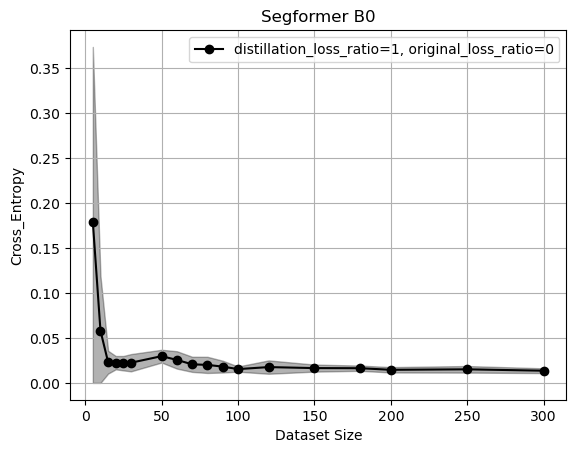

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()